In [28]:
import torch
import pandas as pd
from torch_geometric.nn import HeteroConv, Linear, SAGEConv, GATConv, to_hetero
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.profile import count_parameters



In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
import itertools

ATTRIBUTE_ENCODING_LENGTH = 10
EXTRA_NODE_TYPES = ["order", "customer"]
NUM_CATEGORIES = 32
NUM_SIZES = 29
NUM_COLORS = 642

pairs = list(itertools.product(range(NUM_CATEGORIES), range(NUM_SIZES)))
CATGORY_SIZE_INDEX = {pair: i for i, pair in enumerate(pairs)}


In [31]:
class IdentityEncoder:
    def __init__(self, dtype=None):
        self.dtype = dtype

    def __call__(self, df):
        return torch.from_numpy(df.values).view(-1, 1).to(self.dtype)
    
class PairToOneEncoder:
    def __init__(self, dtype=None):
        self.dtype = dtype

    def __call__(self, df):
        v = df.apply(lambda x: CATGORY_SIZE_INDEX[tuple(x)], axis=1)
        return torch.from_numpy(v.values).view(-1, 1).to(self.dtype)

In [32]:
def load_node_csv(path, index_col, encoders=None, **kwargs):
    df = pd.read_csv(path, index_col=index_col, **kwargs)
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

In [33]:
def load_edge_csv(path, src_index_col, src_mapping, dst_index_col, dst_mapping,
                  attr_encoders=None,label_encoders = None ,**kwargs):
    df = pd.read_csv(path, **kwargs)

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    edge_attr = None
    edge_label = None
    
    if attr_encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in attr_encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)
    if label_encoders is not None:
        edge_labels = [encoder(df[col]) for col, encoder in label_encoders.items()]
        edge_label = torch.cat(edge_labels, dim=-1)

    return edge_index, edge_attr, edge_label

In [34]:
customer_encoders = {col_name : IdentityEncoder(dtype=torch.float32) for col_name in ["n_orders","n_not_returned","n_partial_returned","n_fully_returned","n_products"]}
order_encoders = {col_name : IdentityEncoder(dtype=torch.float32) for col_name in ["n_products"]}
# product_encoders = {col_name : IdentityEncoder(dtype=torch.float32) for col_name in ["n_orders", "n_returned", "n_customers"]}
product_encoders = {col_name : IdentityEncoder(dtype=torch.float32) for col_name in ["return_rate"]}
customer_x, customer_mapping = load_node_csv('data/customer_node_attributes.csv', index_col='customer', encoders=customer_encoders)
order_x, order_mapping = load_node_csv('data/order_node_attributes.csv', index_col='order', encoders=order_encoders)
# product_x, product_mapping = load_node_csv('data/product_node_attributes.csv', index_col='product', encoders=product_encoders)
product_x, product_mapping = load_node_csv('product_stats.csv', index_col='product', encoders=product_encoders)


In [35]:
customer_order_edge_attr_encoders = {col_name : IdentityEncoder(dtype=torch.float32) for col_name in ["n_products","train_masks","valid_masks","test_masks"]}
customer_order_edge_label_encoders = {"label" : IdentityEncoder(torch.long)}
order_product_edge_attr_encoders = {col_name : IdentityEncoder(dtype=torch.long) for col_name in ["color", "size"]}
order_product_edge_label_encoders = {"label" : IdentityEncoder(torch.long)}

customer_order_edge_index, customer_order_edge_attr, customer_order_edge_label = load_edge_csv('data/customer_edgelist.csv', 
                                                                                               'customer', customer_mapping, 
                                                                                               'order', order_mapping, 
                                                                                               attr_encoders=customer_order_edge_attr_encoders, 
                                                                                               label_encoders=customer_order_edge_label_encoders)
order_product_edge_index, order_product_edge_attr, order_product_edge_label = load_edge_csv('data/order_edgelist.csv',
                                                                                            'order', order_mapping, 
                                                                                            'product', product_mapping, 
                                                                                            attr_encoders=order_product_edge_attr_encoders,
                                                                                            label_encoders=order_product_edge_label_encoders)

In [9]:
order_product_edge_attr

tensor([[611.,  10.],
        [611.,  17.],
        [398.,  10.],
        ...,
        [406.,  17.],
        [269.,  24.],
        [302.,  24.]])

In [36]:
from torch_geometric.data import HeteroData

data = HeteroData()

customer_mapping = []
order_mapping = []
item_mapping = []

# Try not using features but learning embeddings for nodes
# data['order'].x = order_x
data['order'].num_nodes = len(order_x)
data['product'].x = product_x
# data['customer'].x = customer_x
data['customer'].num_nodes = len(customer_x)
data['customer', 'order'].edge_index = customer_order_edge_index
data['customer', 'order'].edge_attr = customer_order_edge_attr
data['customer', 'order'].edge_label = customer_order_edge_label

data['order',  'product'].edge_index = order_product_edge_index
data['order',  'product'].edge_attr = order_product_edge_attr
data['order',  'product'].edge_label = order_product_edge_label

data = T.ToUndirected()(data)
data = data.to(device)
del data['order', 'rev_to', 'customer'].edge_label
del data['product', 'rev_to', 'order'].edge_label
print(data)

HeteroData(
  order={ num_nodes=849185 },
  product={ x=[58415, 1] },
  customer={ num_nodes=342038 },
  (customer, to, order)={
    edge_index=[2, 849185],
    edge_attr=[849185, 4],
    edge_label=[849185, 1],
  },
  (order, to, product)={
    edge_index=[2, 2280200],
    edge_attr=[2280200, 2],
    edge_label=[2280200, 1],
  },
  (order, rev_to, customer)={
    edge_index=[2, 849185],
    edge_attr=[849185, 4],
  },
  (product, rev_to, order)={
    edge_index=[2, 2280200],
    edge_attr=[2280200, 2],
  }
)


In [37]:
data[("order", "to", "product")]["edge_attr"]

tensor([[611,  10],
        [611,  17],
        [398,  10],
        ...,
        [406,  17],
        [269,  24],
        [302,  24]])

In [16]:
from torch_geometric.nn import HANConv

class HAN(torch.nn.Module):
    def __init__(self, in_channels: int,
                 out_channels: int, hidden_channels=128, heads=8):
        super().__init__()
        self.han_conv = HANConv(in_channels, hidden_channels, heads=heads,
                                dropout=0.6, metadata=data.metadata())
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict, edge_attr_dict=None):
        out = self.han_conv(x_dict, edge_index_dict)
        out = self.lin(out["order"])
        return out

In [89]:
from torch_geometric.utils import trim_to_layer

# Does not work
class GAT_SAMPLED(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
        self.lin1 = Linear(-1, hidden_channels)
        self.conv2 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
        self.lin2  = Linear(-1, hidden_channels)
        self.conv_final = GATConv((-1, -1), out_channels, add_self_loops=False)
        self.lin_final = Linear(-1, out_channels)
        

    def forward(self, x, edge_index,num_sampled_edges_dict,
                num_sampled_nodes_dict):
        
        for i, conv, lin in enumerate(zip([self.conv1, self.conv2, self.conv_final], [self.lin1, self.lin2, self.lin_final])):
            x, edge_index, _ = trim_to_layer(
                layer=i,
                num_sampled_nodes_per_hop=num_sampled_nodes_dict,
                num_sampled_edges_per_hop=num_sampled_edges_dict,
                x=x,
                edge_index=edge_index,
            )
            x = conv(x, edge_index) + lin(x)
            x = x.relu()

        return x


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
        self.lin1 = Linear(-1, hidden_channels)
        # self.conv2 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
        # self.lin2  = Linear(-1, hidden_channels)
        self.conv_final = GATConv((-1, -1), out_channels, add_self_loops=False)
        self.lin_final = Linear(-1, out_channels)
        

    def forward(self, x, edge_index, edge_attr):
    
        x = self.conv1(x, edge_index,edge_attr) + self.lin1(x)
        x = x.relu()
        # x = self.conv2(x, edge_index,edge_attr) + self.lin2(x)
        # x = x.relu()
        x = self.conv_final(x, edge_index,edge_attr) + self.lin_final(x)
        return x
    
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)
        

    def forward(self, x, edge_index, edge_attr):
        print(x.shape, edge_index.shape, edge_attr.shape)
        x = self.conv1(x, edge_index).relu()
        print(x.shape)
        x = self.conv2(x, edge_index)
        print("2",x.shape)
        return x

In [93]:
import copy
# GNN + Node embedding
class MyModel(torch.nn.Module):
    def __init__(self, model, embedding_dim):
        super(MyModel, self).__init__()
        self.model = model
        node_embeddings = {
                nt: torch.nn.Embedding(data[nt]["num_nodes"], embedding_dim)
                    for nt in EXTRA_NODE_TYPES
                }
        self.node_embeddings = torch.nn.ModuleDict(node_embeddings)

        feature_embeddings = {}
        feature_embeddings["color"] = torch.nn.Embedding(NUM_COLORS, embedding_dim)
        feature_embeddings["category"] = torch.nn.Embedding(NUM_CATEGORIES, embedding_dim)
        feature_embeddings["size"] = torch.nn.Embedding(NUM_SIZES, embedding_dim)
        self.feature_embeddings = torch.nn.ModuleDict(feature_embeddings)
        
        self.product_lin = torch.nn.Linear(1, embedding_dim)
        

    def forward(self, x, edge_index, edge_attr):
        
        x = copy.copy(x)
        edge_index = copy.copy(edge_index)
        edge_attr = copy.copy(edge_attr)    
        for nt in EXTRA_NODE_TYPES:
                x[nt] = self.node_embeddings[nt].weight
        x["product"] = self.product_lin(x["product"])
        c_e = self.feature_embeddings["color"](edge_attr[('order', 'to', 'product')][:,0])
        s_e = self.feature_embeddings["size"](edge_attr[('order', 'to', 'product')][:,1]) 
        edge_attr[('order', 'to', 'product')] = torch.cat([c_e,s_e],dim=-1)
        # print(x.keys(), edge_index.keys())                
        return self.model(x, edge_index,edge_attr)

In [91]:
@torch.no_grad()
def init_params(n_model):
    # Initialize lazy parameters via forwarding a single batch to the model:
    output = n_model(data.x_dict, data.edge_index_dict, data.edge_attr_dict)
    return output

In [40]:
from torch_geometric.loader import NeighborLoader

kwargs = {'batch_size': 1024, 'num_workers': 0}
# Samplers, DOES NOT WORK
train_loader = NeighborLoader(
    data,
    num_neighbors=[10] * 2,
    shuffle=True,
    input_nodes=("order", data['customer', 'order'].edge_attr[:,-3].bool()),
    **kwargs
)

val_loader = NeighborLoader(
    data,
    num_neighbors=[10] * 2,
    shuffle=False,
    input_nodes=('order', data['customer', 'order'].edge_attr[:,-2].bool()),
    **kwargs
)

In [94]:
# Models learn, overfit but does not generalize

# model = GNN(hidden_channels=64, out_channels=3)
model = GAT(hidden_channels =  64,out_channels =3)
model = to_hetero(model, data.metadata(), aggr='sum').to(device)
# model = HAN(in_channels = -1, out_channels = 3, hidden_channels=64, heads=8).to(device)
embedded_model = MyModel(model, embedding_dim=15).to(device)
optimizer = torch.optim.Adam(embedded_model.parameters(), lr=0.001)

# https://github.com/pyg-team/pytorch_geometric/issues/3604
# Learn embeddings
output = init_params(embedded_model)

In [16]:
from tqdm import tqdm
# Does not work, Sampled training
def train_batched(model,loader):
    model.train()

    total_examples = total_loss = 0
    for batch in tqdm(loader):
        batch = batch.to(device)
        optimizer.zero_grad()

        out = model(
            batch.x_dict,
            batch.edge_index_dict,
            num_sampled_nodes_dict=batch["order"]["num_nodes"],
            num_sampled_edges_dict=batch.num_sampled_edges_dict,
        )
        batch_size = batch['order'].batch_size
        loss = F.cross_entropy(out[:batch_size], batch['customer','order'].edge_label[:batch_size].squeeze())
        loss.backward()
        optimizer.step()

        total_examples += batch_size
        total_loss += float(loss) * batch_size

    return total_loss / total_examples

In [97]:

def train(model):
    model.train()
    optimizer.zero_grad()
    output = model(data.x_dict, data.edge_index_dict,data.edge_attr_dict
                 )
    # edge_attr[:,-3] - train mask
    mask = data['customer', 'order'].edge_attr[:,-3].bool()

    pred = F.softmax(output["order"][mask], dim=-1)
    target = data['customer', 'order'].edge_label[mask].squeeze()
    loss = F.cross_entropy(pred, target)
    loss.backward()
    optimizer.step()
    return float(loss)

In [98]:
from tqdm import tqdm
@torch.no_grad()
def test(model, test_set):
    model.eval()
    output = model(data.x_dict, data.edge_index_dict,data.edge_attr_dict
                 )
    # edge_attr[:,-3] - train mask
    if test_set == "train":
        mask_index = -3
    elif test_set == "valid":
        mask_index = -2
    elif test_set == "test":
        mask_index = -1
    else:
        raise ValueError("Invalid set for testing")
    mask = data['customer', 'order'].edge_attr[:,mask_index].bool()
    pred = F.softmax(output["order"][mask], dim=-1)
    target = data['customer', 'order'].edge_label[mask].squeeze()
    pred = pred.argmax(dim=-1)
    total_correct = pred.eq(target).sum().item()
    total_0 = pred.eq(0).sum().item()
    total_1 = pred.eq(1).sum().item()
    total_2 = pred.eq(2).sum().item()
    print(f"Total correct: {total_correct}, Total 0: {total_0}, Total 1: {total_1}, Total 2: {total_2}")
    


    return total_correct / mask.sum().item(), total_0/ mask.sum().item(), total_1/ mask.sum().item(), total_2/ mask.sum().item()

In [99]:
losses = []
train_accs = []
valid_accs = []
valid_dist = []
for epoch in range(1, 300):
    loss = train(embedded_model)
    losses.append(loss)
    
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')
    if epoch % 10 == 0:
        train_acc, _, _, _ = test(embedded_model, "train")
        valid_acc, z, o,t = test(embedded_model, "valid")
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
        valid_dist.append([z,o,t])
        print(f"Train accuracy: {train_acc}")
        print(f"Valid accuracy: {valid_acc}")


    


Epoch: 01, Loss: 1.1207
Epoch: 02, Loss: 1.1104
Epoch: 03, Loss: 1.1023
Epoch: 04, Loss: 1.0964
Epoch: 05, Loss: 1.0922
Epoch: 06, Loss: 1.0893
Epoch: 07, Loss: 1.0874
Epoch: 08, Loss: 1.0860
Epoch: 09, Loss: 1.0850
Epoch: 10, Loss: 1.0842
Total correct: 231923, Total 0: 243924, Total 1: 349084, Total 2: 1422
Total correct: 48271, Total 0: 52371, Total 1: 74669, Total 2: 337
Train accuracy: 0.39016032165267567
Valid accuracy: 0.3789616649787638


KeyboardInterrupt: 

<Axes: >

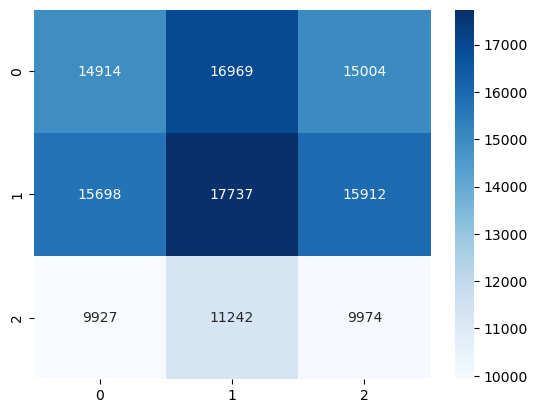

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
embedded_model.eval()
output = embedded_model(data.x_dict, data.edge_index_dict,
                )
mask_index = -2
mask = data['customer', 'order'].edge_attr[:,mask_index].bool()
pred = F.softmax(output["order"][mask], dim=-1)
target = data['customer', 'order'].edge_label[mask].squeeze()
pred = pred.argmax(dim=-1)

cfm = confusion_matrix(target.cpu().numpy(), pred.cpu().numpy())
sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')

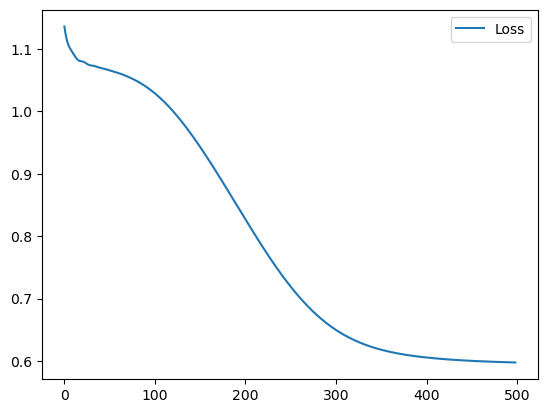

In [21]:
import matplotlib.pyplot as plt
plt.plot(losses)

plt.legend(["Loss"])
plt.show()

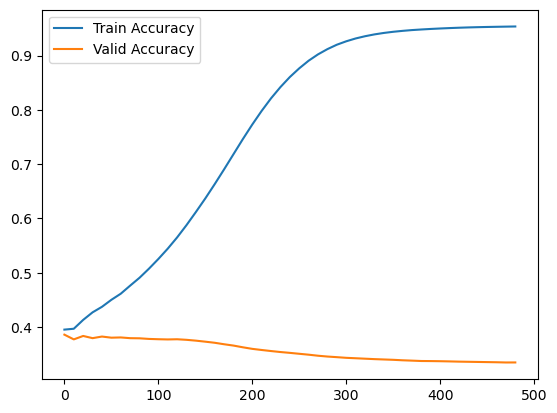

In [22]:
import numpy as np
plt.plot(train_accs)
plt.plot(valid_accs)
plt.xticks(np.arange(0, 51, 10), np.arange(0, 510, 100))  # Set the x-ticks

plt.legend(["Train Accuracy", "Valid Accuracy"])
plt.show()

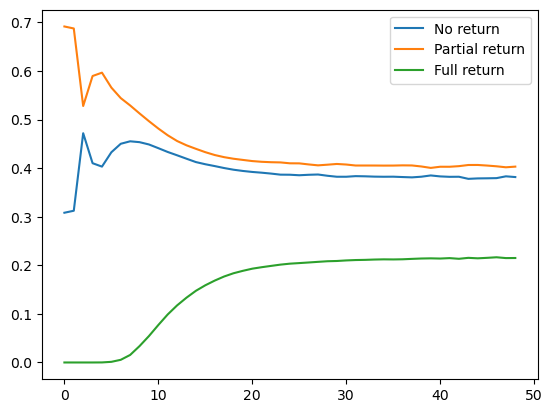

In [32]:
import numpy as np
valid_dist = np.array(valid_dist)
plt.plot(valid_dist[:,0])
plt.plot(valid_dist[:,1])
plt.plot(valid_dist[:,2])
plt.legend(["No return", "Partial return", "Full return"])
plt.show()